## library

In [1]:
import kagglehub
from pathlib import Path
import cv2
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import keras
from keras import layers
from keras import Sequential

## reading data

In [2]:
path = kagglehub.dataset_download("tongpython/cat-and-dog")
data_dir = Path(path) # str to posix path obj
train_images_address = list(data_dir.glob("training_set/*/*/*.jpg")) # image address
test_images_address = list(data_dir.glob("test_set/*/*/*.jpg"))

Using Colab cache for faster access to the 'cat-and-dog' dataset.


## tf.data

In [3]:
# 1. Define image parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# 2. Function to extract labels and process images
def process_path(file_path):
    # Extract label from the path: .../cats/... or .../dogs/...
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label = tf.cast(label == "dogs", tf.int32) # 1 for dog, 0 for cat

    # Read and decode image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalization
    return img, label

# 3. Create the tf.data.Dataset
# Convert PosixPath list to string list for TF
train_paths = [str(p) for p in train_images_address]
test_paths = [str(p) for p in test_images_address]

train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_ds = test_ds.map(process_path).batch(BATCH_SIZE)

## model architecture

In [4]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation="sigmoid")
])

## loss and optimizer

In [5]:
model.compile(
  optimizer='adam',
  loss="binary_crossentropy",
  metrics=['accuracy'])

## training

In [6]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 28s 86ms/step - accuracy: 0.9242 - loss: 0.3359 - val_accuracy: 0.4998 - val_loss: 0.6981
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.1701 - loss: 0.7524 - val_accuracy: 0.4998 - val_loss: 0.6970
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.1712 - loss: 0.7456 - val_accuracy: 0.4998 - val_loss: 0.6964
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.1708 - loss: 0.7409 - val_accuracy: 0.4998 - val_loss: 0.6960
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.1707 - loss: 0.7370 - val_accuracy: 0.4998 - val_loss: 0.6956
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.1712 - loss: 0.7336 - val_accuracy: 0.4998 - val_loss: 0.6953
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.1699 - loss: 0.7307 - val_accuracy: 0.4998 - val_loss: 0.6951
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.1704 - loss: 0.7282 - 

## result

Text(0.5, 0, 'epoch')

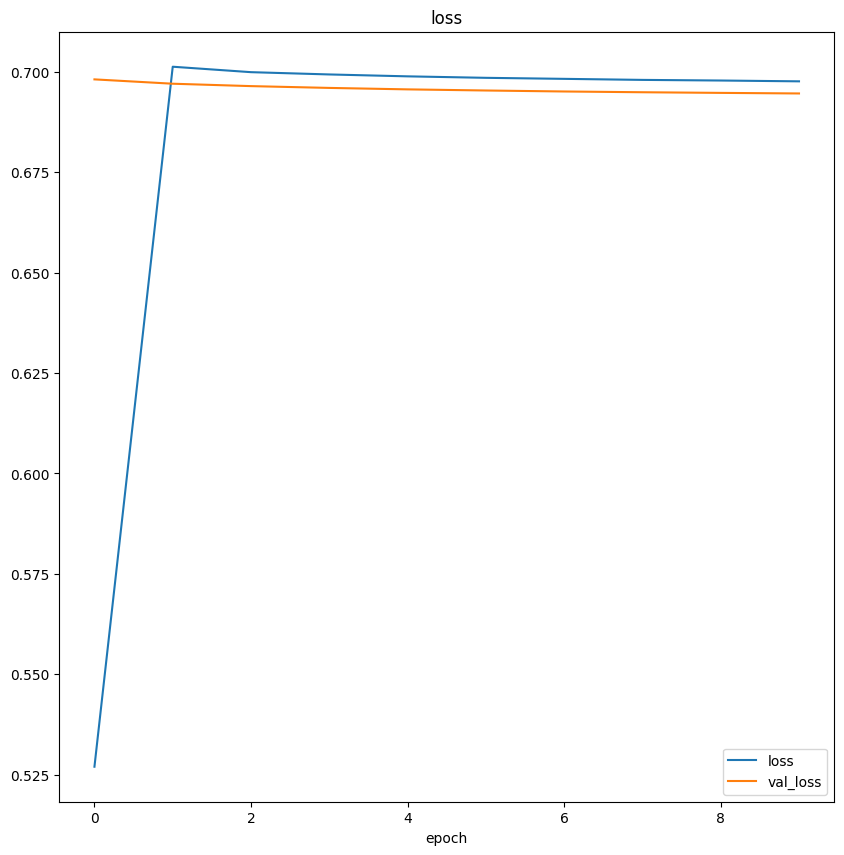

In [7]:
plt.figure(figsize=(10, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("loss")
plt.legend(["loss", "val_loss"])
plt.xlabel("epoch")